In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/keystrokes/raw/fixed-text.csv")
df.head()

,participant,session,repetition,DU.v.v,DD.v.p,DU.v.p,UD.v.p,UU.v.p,DU.p.p,DD.p.w,...,DU.r.k,UD.r.k,UU.r.k,DU.k.k.1,DD.k.b,DU.k.b,UD.k.b,UU.k.b,DU.b.b,total time
0,p001,1,1,0.129,1.917,1.804,2.046,1.933,0.113,0.719,...,1.289,1.509,1.423,0.086,0.450,0.352,0.536,0.438,0.098,10.101
1,p001,1,2,0.112,0.192,0.096,0.304,0.208,0.096,0.448,...,0.921,1.135,1.056,0.079,0.418,0.336,0.497,0.415,0.082,5.768
2,p001,1,3,0.088,0.253,0.182,0.341,0.270,0.071,1.536,...,1.066,1.271,1.194,0.077,0.448,0.352,0.525,0.429,0.096,7.877
3,p001,1,4,0.104,0.323,0.233,0.427,0.337,0.090,0.912,...,0.927,1.129,1.063,0.066,0.418,0.330,0.484,0.396,0.088,5.443
4,p001,1,5,0.107,0.188,0.100,0.295,0.207,0.088,0.858,...,1.237,1.423,1.344,0.079,0.457,0.369,0.536,0.448,0.088,5.284


In [3]:
df_raw = df.copy()

In [4]:
timing_cols = df.columns[3:-1] 

In [5]:
df_clean = df.copy()
df_clean[timing_cols] = df_clean[timing_cols].apply(pd.to_numeric, errors='coerce')
df_clean[timing_cols] = df_clean[timing_cols].clip(lower=0)
df_clean[timing_cols] = df_clean[timing_cols].fillna(0)

In [7]:
def create_features(df):
    timing_cols = df.columns[3:-1]

    df['mean_timing'] = df[timing_cols].mean(axis=1)
    df['std_timing'] = df[timing_cols].std(axis=1)
    df['min_timing'] = df[timing_cols].min(axis=1)
    df['max_timing'] = df[timing_cols].max(axis=1)
    df['median_timing'] = df[timing_cols].median(axis=1)

    df['WPM'] = 120 / df['total time']

    return df

In [8]:
df_raw = create_features(df_raw)
df_clean = create_features(df_clean)

In [9]:
df_raw.head()

,participant,session,repetition,DU.v.v,DD.v.p,DU.v.p,UD.v.p,UU.v.p,DU.p.p,DD.p.w,...,UD.k.b,UU.k.b,DU.b.b,total time,mean_timing,std_timing,min_timing,max_timing,median_timing,WPM
0,p001,1,1,0.129,1.917,1.804,2.046,1.933,0.113,0.719,...,0.536,0.438,0.098,10.101,0.914283,0.731605,0.054,2.436,0.8055,11.880012
1,p001,1,2,0.112,0.192,0.096,0.304,0.208,0.096,0.448,...,0.497,0.415,0.082,5.768,0.532870,0.489346,0.044,1.616,0.3600,20.804438
2,p001,1,3,0.088,0.253,0.182,0.341,0.270,0.071,1.536,...,0.525,0.429,0.096,7.877,0.713783,0.674333,0.036,2.375,0.4485,15.234226
3,p001,1,4,0.104,0.323,0.233,0.427,0.337,0.090,0.912,...,0.484,0.396,0.088,5.443,0.503804,0.347769,0.066,1.129,0.4125,22.046665
4,p001,1,5,0.107,0.188,0.100,0.295,0.207,0.088,0.858,...,0.536,0.448,0.088,5.284,0.489043,0.422840,0.064,1.423,0.3450,22.710068


In [10]:
df_clean.head()

,participant,session,repetition,DU.v.v,DD.v.p,DU.v.p,UD.v.p,UU.v.p,DU.p.p,DD.p.w,...,UD.k.b,UU.k.b,DU.b.b,total time,mean_timing,std_timing,min_timing,max_timing,median_timing,WPM
0,p001,1,1,0.129,1.917,1.804,2.046,1.933,0.113,0.719,...,0.536,0.438,0.098,10.101,0.914283,0.731605,0.054,2.436,0.8055,11.880012
1,p001,1,2,0.112,0.192,0.096,0.304,0.208,0.096,0.448,...,0.497,0.415,0.082,5.768,0.532870,0.489346,0.044,1.616,0.3600,20.804438
2,p001,1,3,0.088,0.253,0.182,0.341,0.270,0.071,1.536,...,0.525,0.429,0.096,7.877,0.713783,0.674333,0.036,2.375,0.4485,15.234226
3,p001,1,4,0.104,0.323,0.233,0.427,0.337,0.090,0.912,...,0.484,0.396,0.088,5.443,0.503804,0.347769,0.066,1.129,0.4125,22.046665
4,p001,1,5,0.107,0.188,0.100,0.295,0.207,0.088,0.858,...,0.536,0.448,0.088,5.284,0.489043,0.422840,0.064,1.423,0.3450,22.710068


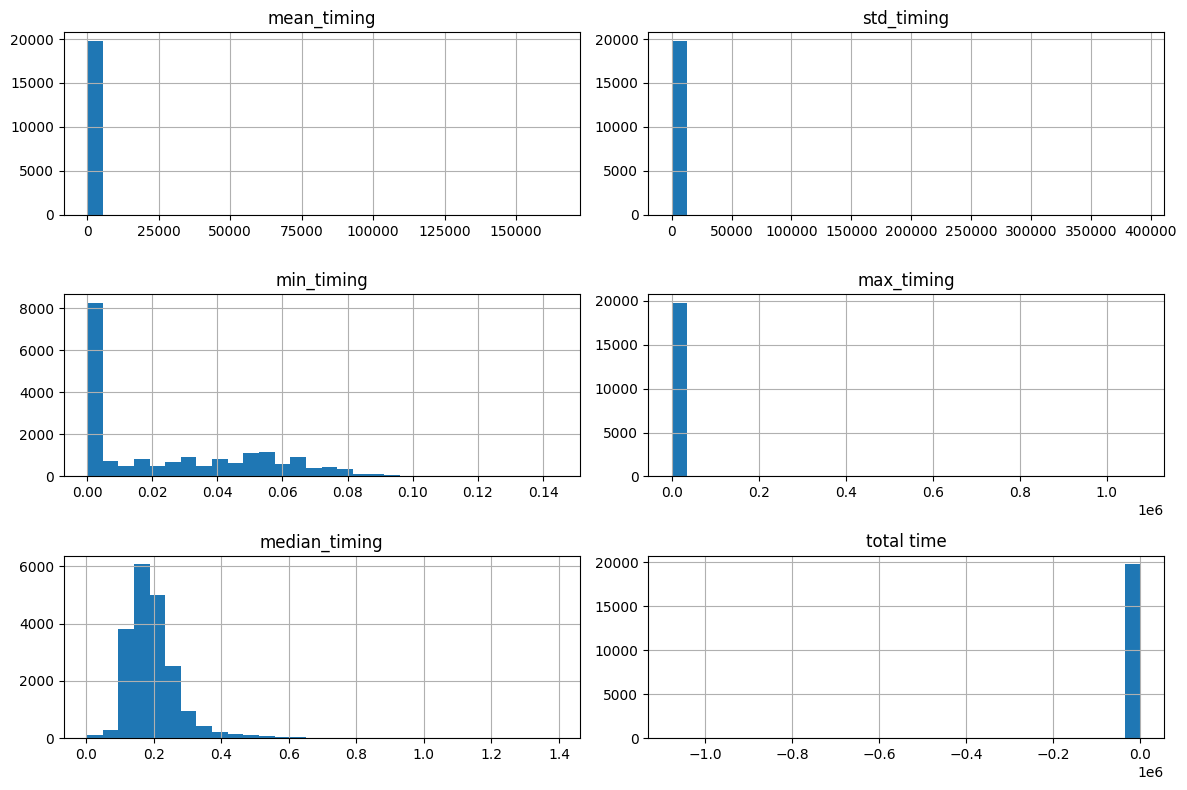

In [11]:
df_clean[["mean_timing", "std_timing", "min_timing", "max_timing", 
          "median_timing", "total time"]].hist(bins=30, figsize=(12,8))
plt.tight_layout()
plt.show()

In [12]:
feature_cols = ['mean_timing','std_timing','min_timing','max_timing','median_timing','total time']
target_col = 'WPM'

# RAW
X_raw = df_raw[feature_cols]
y_raw = df_raw[target_col]

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_raw, y_raw, test_size=0.3, random_state=42
)

# CLEANED
X_clean = df_clean[feature_cols]
y_clean = df_clean[target_col]

X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    X_clean, y_clean, test_size=0.3, random_state=42
)

---


## Data Preprocessing for Fixed Text Keystroke Dynamics
### Cleaning Data, Handling Negative Values (Overlap), and Calculating Target Variable (WPM)

In [ ]:
# --- Data Preprocessing for Fixed Text Keystroke Dynamics ---

# NOTE: If you previously loaded the data into a DataFrame named 'df' or 'df_raw',
# ensure you use the correct variable here. We assume 'df' is loaded or is loaded here.
try:
    # Attempt to read the file in the current working directory
    df = pd.read_csv("fixed-text.csv")
except FileNotFoundError:
    # Fallback/Suggestion: Use the relative path often seen in your notebook structure
    # df = pd.read_csv("../data/keystrokes/raw/fixed-text.csv")
    print("Error: 'fixed-text.csv' not found. Please adjust the file path.")
    # Stop execution if data cannot be loaded
    # exit()

# Identify all float columns for outlier checking and feature usage
float_cols = df.select_dtypes(include=['float64']).columns

# --- 2. Handle Corrupted Negative Outliers ---
# Small negative values (representing key overlap) are kept AS-IS, as they are meaningful features.
# Only the massive negative values (sentinel codes for corrupted data) are removed.

OUTLIER_THRESHOLD = -1000000

# Create a mask to identify rows where ANY float column is below the outlier threshold
outlier_rows_mask = (df[float_cols] < OUTLIER_THRESHOLD).any(axis=1)

# Remove the identified outlier rows
df_cleaned = df[~outlier_rows_mask].copy()

# Report on the cleaning step
removed_rows_count = outlier_rows_mask.sum()
print(f"Removed {removed_rows_count} row(s) containing corrupted sentinel negative values.")
print(f"Remaining rows in dataset: {len(df_cleaned)}")


# --- 3. Calculate Target Variable: Word Per Minute (WPM) ---
# The fixed text is "vp wjkeurkb", which has 10 characters (keys).
NUM_CHARS = 10 

# WPM calculation: (Characters / 5) / (Total Time in minutes)
df_cleaned['WPM'] = (NUM_CHARS / 5) / (df_cleaned['total time'] / 60)


# --- 4. Prepare Final Feature Set and Save ---
# Exclude 'total time' from features as WPM is directly derived from it.
feature_cols = [col for col in float_cols if col not in ['total time']]

# Final DataFrame structure for ML
df_ml = df_cleaned[['participant', 'session', 'repetition', 'WPM'] + feature_cols].copy()

# Save the Cleaned Data 
output_filename = "fixed_text_cleaned_for_ml.csv"
df_ml.to_csv(output_filename, index=False)

print(f"\nCleaned and preprocessed data saved to '{output_filename}'.")
print("\nFirst 5 rows of the final ML-ready DataFrame with WPM:")
print(df_ml.head())